In [30]:
import pyabc
import scipy
import numpy as np
from datetime import datetime
import pandas as pd
from arviz import hdi
import numpy as np
import matplotlib.pyplot as plt

path = '../../results'
output_path = '../../figures'

k1 = 'basic-prior'
k2 = 'tau2' 
k103125 = 'tau3332'
k5 = 'tau5' 
k10 = 'tau10'
k100 = 'tau100'

allf = [k1, k103125, k2, k5, k10, k100]
ks = [1,33/32,2,5,10,100]
labels = ['$𝜏=1$','$𝜏=33/32$','$𝜏=2$','$𝜏=5$','$𝜏=10$','$𝜏=100$']

### You can jump to [loading section](#loading) if you want only to plot figures and the data is already persisted

In [31]:
def sample_from_kde(file_name, size=50000):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, file_name))
    samples, weights = history.get_distribution(m=0, t=None)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(),weights=weights)
    kdesamples = kde.resample(2*size).T
    kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
    criteria = (kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) & (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2)
    order_criteria = (kdesamples['2n+1 fitness'] < kdesamples['2n+1* fitness']) & (kdesamples['2n+1* fitness'] < kdesamples['2n* fitness'])
    criteria = criteria & order_criteria
    kdesamples = kdesamples[criteria][:size]
    return kdesamples, kde

In [32]:
import sys  
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1, stopon=3000, fixation=0.95)
N = 6*10**6

In [33]:
%%time
reps = 10_000
res = {}
for f,k in zip(allf, ks):
    samples,kde = sample_from_kde(f)
    p = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                                  and x[1]>1e-6 and x[1]<1e-2 else 100000
                                  ,samples.median().values)['x']
    p = [p[0],p[1],p[1],*p[2:]] # aneuploidy gain and loss rates are the same
    model = SingleLocusModel(k=k, stopon=3000, fixation=0.95)
    times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
    g = model.grade_function2(times_p)
    print(f,-g, p)
    res[f] = (times_p,-g)

basic-prior 0.8355349112522208 [2.930903624833154e-06, 0.0017214414833612902, 0.0017214414833612902, 1.0221534257939067, 1.0247282903500576, 1.0278865065170253]
tau3332 0.8588235941060958 [2.5389960801762446e-06, 0.0015246761115680605, 0.0015246761115680605, 1.021599452353623, 1.0252091604031555, 1.0273471001457324]
tau2 0.8300541113082848 [2.776908860736139e-06, 0.0016125890166127324, 0.0016125890166127324, 1.0222728149589668, 1.0246561297977104, 1.0279590364552422]


/Users/adsurbum/opt/miniconda3/envs/py371/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


tau5 0.7922524413624288 [2.4292625295544835e-06, 0.0020275831158731573, 0.0020275831158731573, 1.0219901936445541, 1.0243012524111166, 1.0276823716103252]
tau10 0.7038303420382688 [1.6615512652870855e-06, 0.0014754388265362604, 0.0014754388265362604, 1.0223059104473042, 1.0249374613688562, 1.0280300565969922]


/Users/adsurbum/opt/miniconda3/envs/py371/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


tau100 0.10774984519609587 [4.1977201295980633e-07, 0.0010482602722971805, 0.0010482602722971805, 1.0220825312551076, 1.024574367809333, 1.027947701652134]
CPU times: user 1h 20min 23s, sys: 1min 59s, total: 1h 22min 22s
Wall time: 1h 34min 16s


In [34]:
np.savez_compressed('./outputs/tau_plots1',res=res)

<a id='loading'></a>
### loading section

In [35]:
l = np.load('./outputs/tau_plots1.npz',allow_pickle=True)
res = l['res'][()]

In [36]:
len(res)

6

In [37]:
def fixation_progress(times_p, w):
    times, p = times_p
    res = [len([b for b in a if b>0.95])/reps for a in np.array(p)[:,w][:3000,]]
    if len(res)!=3000:
        res = res+[res[-1]]*(3000-len(res))
    return res

In [38]:
fixations0 = [fixation_progress(res[f][0], 0) for f in allf]
fixations1 = [fixation_progress(res[f][0], 1) for f in allf]
fixations2 = [fixation_progress(res[f][0], 2) for f in allf]
fixations3 = [fixation_progress(res[f][0], 3) for f in allf]

In [39]:
import seaborn as sns
from numpy import linspace
from matplotlib import cm
def plot_accumulated_fixation(progress_arr, labels, w):
    if w=='2n':
        xlimfrom = 0
        xlimto = 60
        l = 'A'
        fixation_label = 'fixation'
    if w=='2n+1':
        xlimfrom = 200
        xlimto = 800
        l = 'B'
        fixation_label = 'fixation'
    elif w=='2n*':
        xlimfrom = 1600
        xlimto = 1800
        l = 'C'
        fixation_label = 'fixation'
        
    
    cm_subsection = np.linspace(0.4, 1.0, 3) 
    colors2 = [ cm.PuRd(x) for x in cm_subsection][::]
    
    cm_subsection = linspace(0.4, 1.0, 3) 
    colors1 = [ cm.BuGn(x) for x in cm_subsection][::]
    
    colors = colors1 + colors2
    
    fig, ax = plt.subplots(figsize=(9, 5))
    for progress,label,color in zip(progress_arr, labels, colors):
        ax.plot(range(len(progress)), progress, label=label, color=color)

    ax.axvline(450,linestyle='--',linewidth=1,color="black")
    ax.axvline(1700,linestyle='--',linewidth=1,color="black")
       
    plt.xlim(xlimfrom, xlimto)
    plt.ylim(-0.07,1.08)
    
    import matplotlib.ticker as mtick
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_yticklabels([int(a) for a in 100*ax.get_yticks()]) # convert to percents
#     ax.set_xticks([0,450,1700,2350])

    plt.xlabel('Time')
    plt.ylabel('% of simulations $f_{'+str(w)+'}>95\%$')
    plt.legend(bbox_to_anchor=(1.26, 1),loc='upper right', fontsize=14) 
    ax.text(-0.1, 1.02, l, transform=ax.transAxes, size=20, weight='bold')

In [40]:
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 1.5, 'lines.markersize': 4})

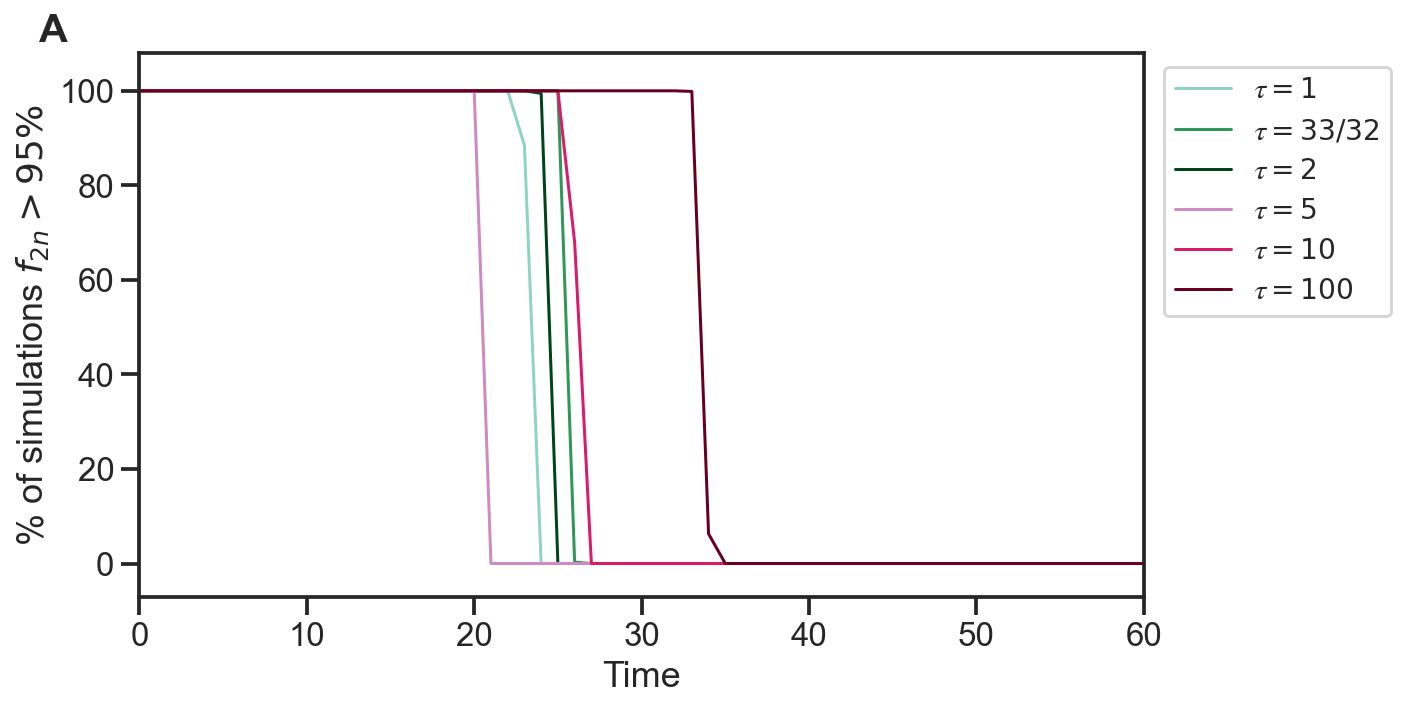

In [41]:
plot_accumulated_fixation(fixations0, labels, '2n')
# plt.gcf().savefig(f'{output_path}/tau-diff-a.pdf', bbox_inches='tight', dpi=100)

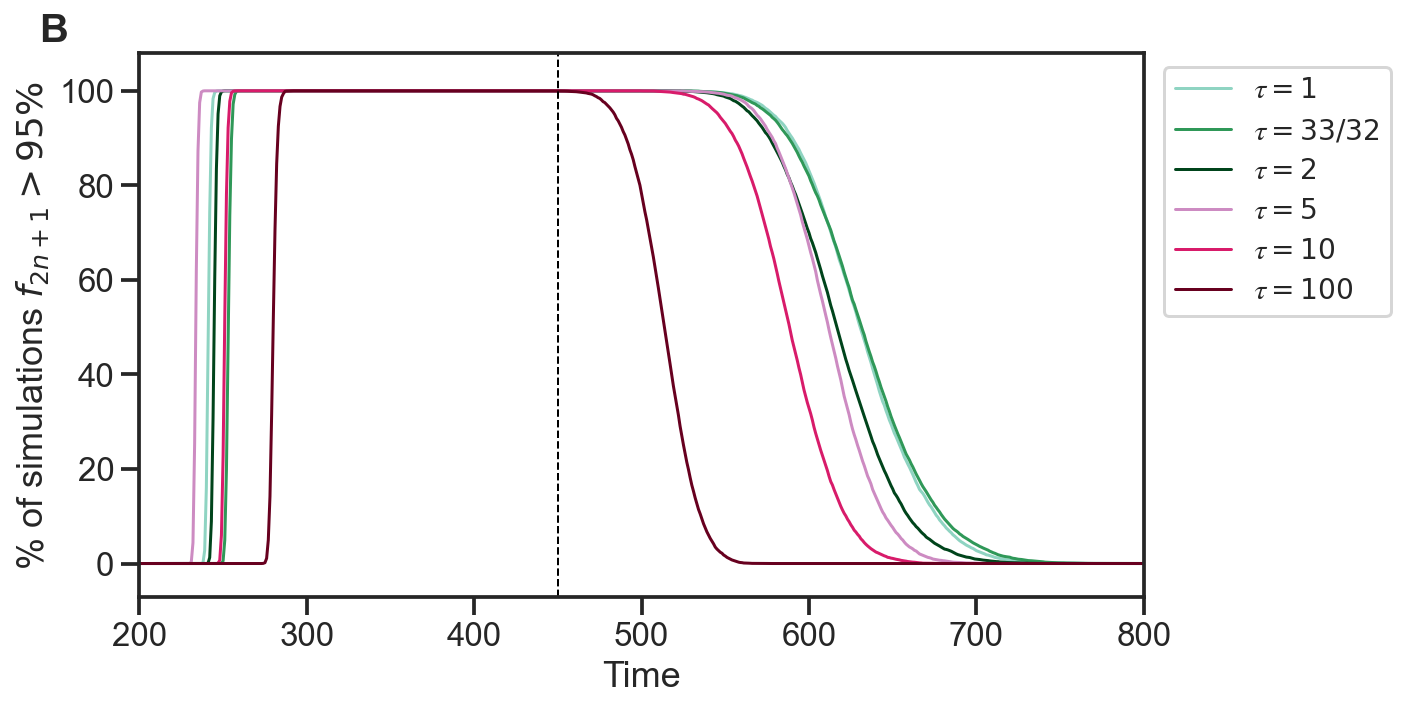

In [42]:
plot_accumulated_fixation(fixations1, labels, '2n+1')
# plt.gcf().savefig(f'{output_path}/tau-diff-b.pdf', bbox_inches='tight', dpi=100)

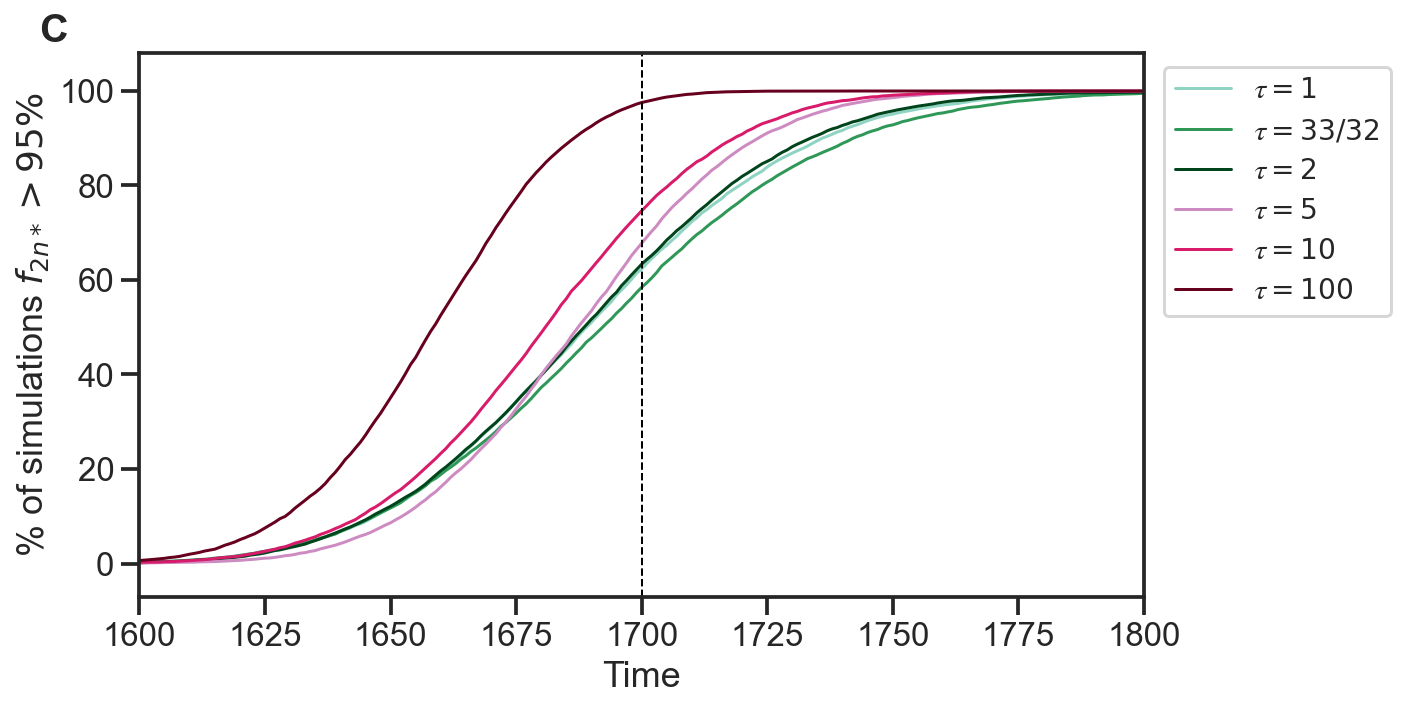

In [43]:
plot_accumulated_fixation(fixations3, labels, '2n*')
# plt.gcf().savefig(f'{output_path}/tau-diff-c.pdf', bbox_inches='tight', dpi=100)